In [38]:
import json
import os
from pyproj import Transformer
import dfm_tools as dfmt
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [39]:
point = 'lugano_melide'
model = 'lugano_1month_10part_corr_thick'
depth_plot = -5 # (for timeserie plots)
date_plot_profile = datetime(2023,8,1,0,0)

# Get plot parameters

In [40]:
with open(os.path.join(os.path.dirname(os.getcwd()), 'config_points.json'), 'r') as file:
    config_plots = json.load(file)[point]
    
lat_station_wgs84 = config_plots['lat_station_wgs84']
long_station_wgs84 = config_plots['long_station_wgs84']
measure_file_path = config_plots['measure_file_path']

In [41]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)

In [42]:
with open('config_plots.json', 'r') as file:
    config_plots = json.load(file)[model]
    
file_nc_map = config_plots['file_nc_map']

In [43]:
file_nc_map

'C:\\Users\\leroquan\\Documents\\00-Work_space\\01-Lake-Lugano_Delft3D-FM\\test_parallel_1m\\parallel_10part_test\\output\\FlowFM_map.nc'

# Import data

In [44]:
fm_map = dfmt.open_partitioned_dataset(file_nc_map)

x_list = fm_map['mesh2d_face_x'].values
y_list = fm_map['mesh2d_face_y'].values
min_distance = sys.maxsize
fm_index_nFaces = None
for i in range(len(x_list)):
    # Calculate distance to the given coordinate
    distance = (x_list[i] - lat_station_ch1903) ** 2 + (y_list[i] - long_station_ch1903) ** 2
    if distance < min_distance:
        min_distance = distance
        fm_index_nFaces = i

fm_depths = fm_map['mesh2d_layer_z'].values
fm_index_depth = (np.abs(fm_depths + depth_plot)).argmin()
fm_timestamps = fm_map['time'].values
fm_timeserie = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, fm_index_depth]
fm_profil = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, :].transpose()

>> xu.open_dataset() with 1 partition(s): 1 [nodomainvar] : 0.07 sec


# Plot data

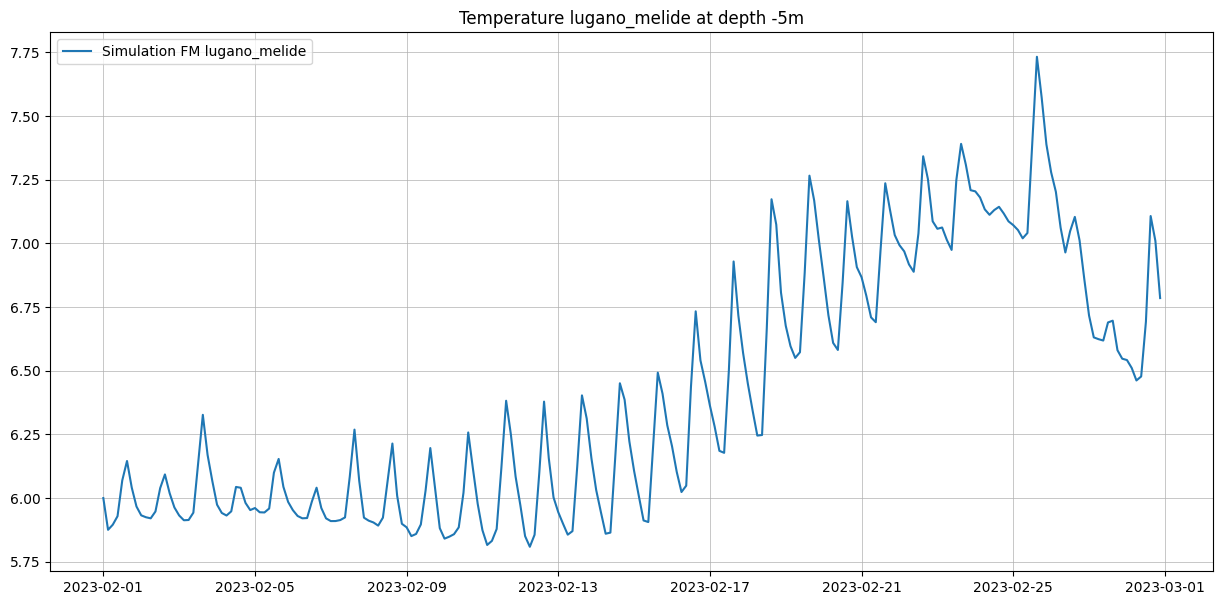

In [45]:
fig = plt.figure(figsize=(15, 7))
plt.plot(fm_timestamps,fm_timeserie, label=f'Simulation FM {point}')
plt.title(f"Temperature {point} at depth {depth_plot}m")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

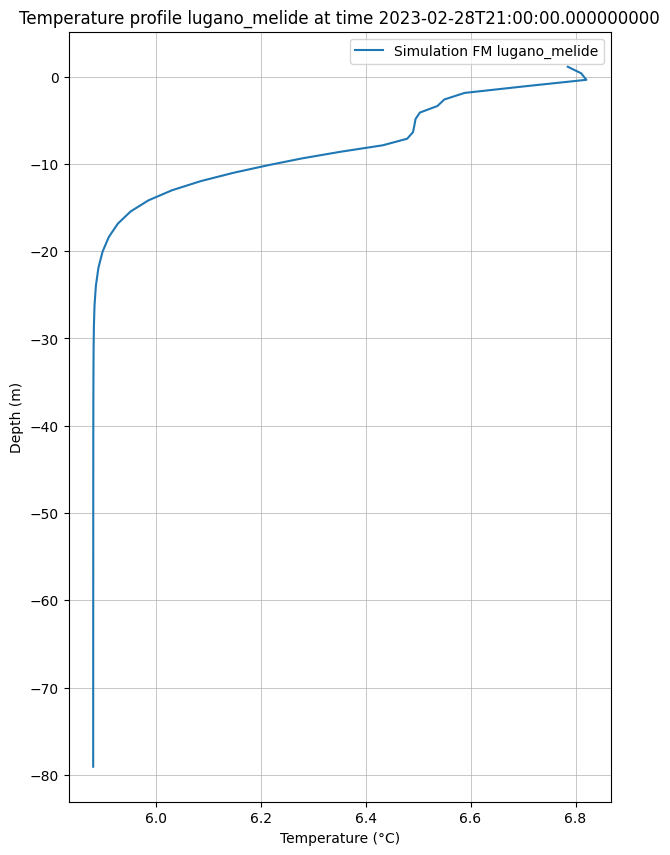

In [46]:
i_fm_date_plot = (np.abs(np.array(fm_timestamps) - np.datetime64(date_plot_profile))).argmin()
fig = plt.figure(figsize=(7, 10))
plt.plot(fm_profil[:,i_fm_date_plot], fm_depths, label=f'Simulation FM {point}') 
plt.title(f"Temperature profile {point} at time {fm_timestamps[i_fm_date_plot]}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.show()

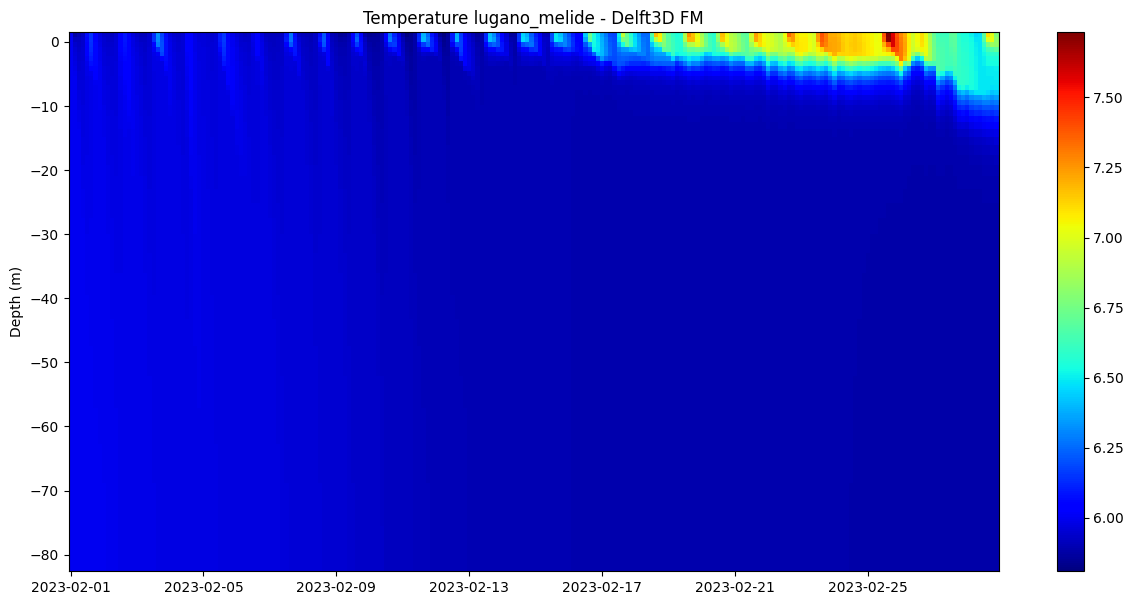

In [47]:
start_date = np.datetime64('2023-02-01') 
end_date = np.datetime64('2023-03-01')

# Find the index of the closest datetime object to start_date and end_date in meas_timestamps
fm_start_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - start_date))
fm_end_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - end_date))
mask_nan_depth = np.isnan(fm_profil[:,0])==False

fig_profil_FLOW = plt.figure(figsize=(15,7))
plt.pcolormesh(fm_timestamps[fm_start_index:fm_end_index + 1], fm_depths[mask_nan_depth], fm_profil[mask_nan_depth,fm_start_index:fm_end_index + 1], cmap='jet')
plt.title(f"Temperature {point} - Delft3D FM")
plt.ylabel("Depth (m)")
plt.colorbar()
plt.show()

In [49]:
fm_depths[mask_nan_depth]

array([-79.06664482, -72.01513166, -65.60466514, -59.77696831,
       -54.4790621 , -49.66278373, -45.28434884, -41.30395349,
       -37.68541227, -34.39582933, -31.40529939, -28.68663581,
       -26.21512347, -23.96829406, -21.92572187, -20.06883807,
       -18.38076188, -16.84614716, -15.45104287, -14.18276625,
       -13.0297875 , -11.981625  , -11.02875   , -10.1625    ,
        -9.375     ,  -8.625     ,  -7.875     ,  -7.125     ,
        -6.375     ,  -5.625     ,  -4.875     ,  -4.125     ,
        -3.375     ,  -2.625     ,  -1.875     ,  -1.125     ,
        -0.375     ,   0.375     ,   1.125     ])